In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="gfzhJKkR2gzJi0YeFpxzITjUq",
  project_name="motorica",
  workspace="morozovov"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'f:\\My_projects\\Motorica' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/morozovov/motorica/0078034f2b224805a6ace24a15f65c33



In [2]:
from sklearn.preprocessing import LabelEncoder

import optuna

# IO utils


In [3]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [4]:
palm_file = './data/2023-05-31_17-14-41.palm'
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [5]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [6]:
# Списки с названиями признаков
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
# Проверка что списки нужной длины
assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


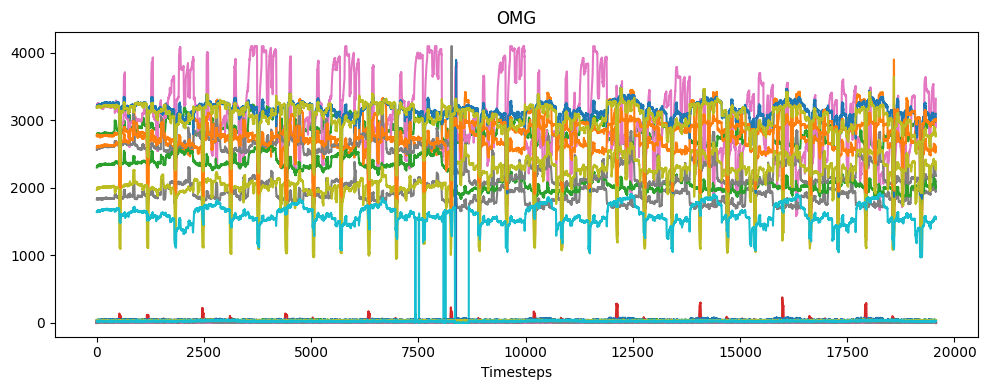

In [7]:
# График показаний датчиков
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [8]:
# Целевые признаки сгибаний и разгибаний пальцев руки
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
178,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [9]:
# Признак SYNC, чтобы узнать сколько записей в конкретной эпохе
gestures.groupby(by='SYNC').count()

,0,1,2,3,4,5,6,7,8,9,...,GYR1,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,ts
SYNC,,,,,,,,,,,,,,,,,,,,,
0,11266,11266,11266,11266,11266,11266,11266,11266,11266,11266,...,11266,11266,11266,11266,11266,11266,11266,11266,11266,11266
1,45,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,45
2,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
3,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
4,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
177,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
178,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46


In [10]:
# Перекодируем 10 признаков в 1 целевой признак 
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
# Оказалось только 6 уникальных комбинаций сгибаний и растягиваний пальцев
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [11]:
# Список всех 6 жестов
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [12]:
# Жесты в разные эпохи, 1 эпоха = 1 жест
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

In [13]:
# Расширяем целевой признак синхронизируя по признаку SYNC
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
print(y_cmd.shape)
y_cmd

(19568,)


array([0, 0, 0, ..., 0, 0, 0])

## Offset Protocol

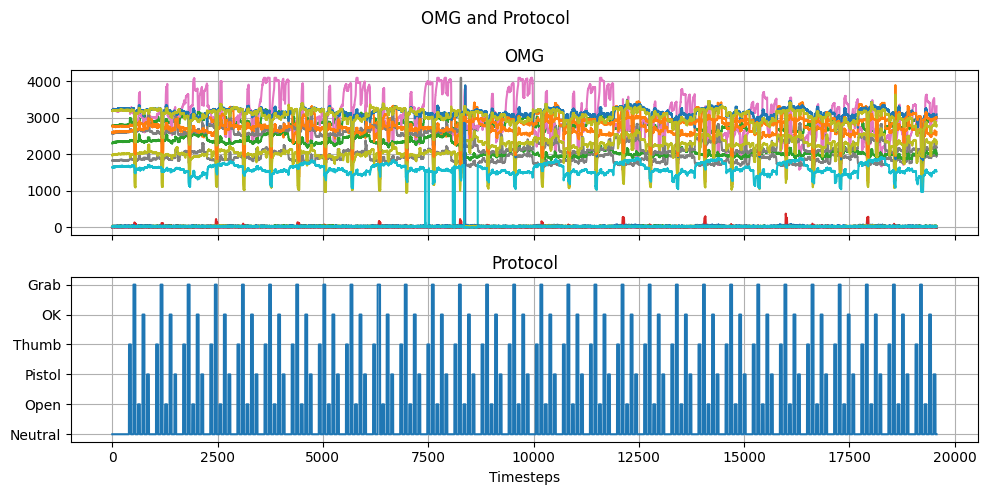

In [14]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.grid()
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

In [15]:
# Функция смещения numpy массива
def shift(arr, n, fill=0):
    if n >= 0:
        return np.concatenate((np.full(n, fill), arr[:-n]))
    else:
        return np.concatenate((arr[-n:], np.full(-n, fill)))

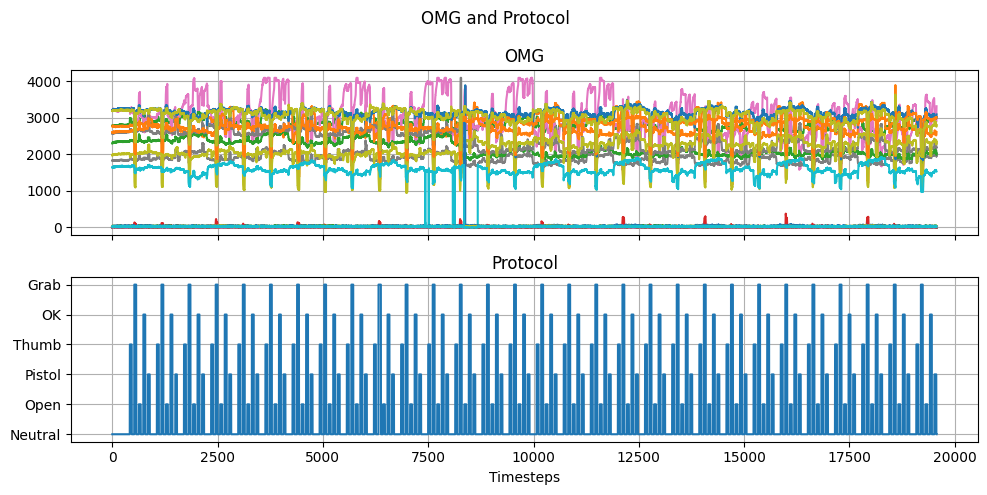

In [16]:
# Смещаем копию и смотрим результат
test = y_cmd.copy()
test = shift(test, n=20) # смещаем на n вправо

fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.grid()
plt.title('OMG')

plt.sca(axx[1])
plt.plot(test)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

In [17]:
# Смещение
y_cmd = shift(y_cmd, n=20) # fill=0 так как в начале у пилота жест Open

# Train-test split

In [18]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [19]:
# Узнаем последний индекс обучающей выборки для нужного файла
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [20]:
# Разделяем данные на обучающую и тестовую по индексу полученному с /data/meta_information.csv
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3889, 50) (3889,)


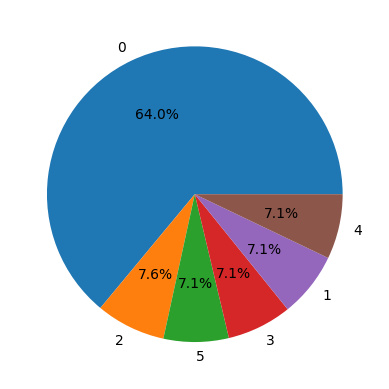

In [21]:
plt.pie(
    pd.DataFrame(y_test)[0].value_counts(),
    labels = pd.DataFrame(y_test)[0].value_counts().index,
    autopct='%.1f%%'
    );

# Modeling

## LinearDiscriminantAnalysis

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics

In [24]:
ldac = LinearDiscriminantAnalysis()

ldac.fit(X_train, y_train)

y_test_pred = ldac.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2488
           1       0.91      0.76      0.83       276
           2       0.86      0.95      0.90       296
           3       0.82      0.42      0.56       276
           4       0.73      0.86      0.79       276
           5       0.94      0.86      0.90       277

    accuracy                           0.89      3889
   macro avg       0.86      0.80      0.82      3889
weighted avg       0.89      0.89      0.88      3889



In [ ]:
# Подбираем параметры:

## LogisticRegressionCV

In [40]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics

In [41]:
lrcv = LogisticRegressionCV(random_state =42)

lrcv.fit(X_train, y_train)

y_test_pred = lrcv.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2488
           1       0.93      0.51      0.66       276
           2       0.54      0.95      0.69       296
           3       0.89      0.37      0.52       276
           4       0.67      0.88      0.76       276
           5       0.79      0.87      0.83       277

    accuracy                           0.82      3889
   macro avg       0.78      0.74      0.72      3889
weighted avg       0.84      0.82      0.81      3889



c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## MLPClassifier

In [56]:
from sklearn.neural_network import MLPClassifier

In [57]:
mlpc = MLPClassifier(random_state =42)

mlpc.fit(X_train, y_train)

y_test_pred = mlpc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2488
           1       0.90      0.78      0.83       276
           2       0.70      0.94      0.80       296
           3       0.92      0.21      0.35       276
           4       0.45      0.91      0.60       276
           5       0.92      0.75      0.82       277

    accuracy                           0.81      3889
   macro avg       0.80      0.74      0.71      3889
weighted avg       0.85      0.81      0.81      3889



## RidgeClassifier

In [96]:
from sklearn.linear_model import RidgeClassifier

rc = RidgeClassifier(random_state=42)

rc.fit(X_train, y_train)

y_test_pred = rc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2488
           1       0.71      0.40      0.51       276
           2       0.67      0.88      0.76       296
           3       0.87      0.29      0.43       276
           4       0.92      0.83      0.87       276
           5       0.91      0.83      0.87       277

    accuracy                           0.82      3889
   macro avg       0.82      0.69      0.72      3889
weighted avg       0.82      0.82      0.80      3889



## RidgeClassifierCV

In [123]:
from sklearn.linear_model import RidgeClassifierCV

rccv = RidgeClassifierCV()

rccv.fit(X_train, y_train)

y_test_pred = rccv.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2488
           1       0.71      0.40      0.51       276
           2       0.67      0.88      0.76       296
           3       0.87      0.29      0.43       276
           4       0.92      0.83      0.87       276
           5       0.91      0.83      0.87       277

    accuracy                           0.82      3889
   macro avg       0.82      0.69      0.72      3889
weighted avg       0.82      0.82      0.80      3889



## ExtraTreeClassifier

In [37]:
from sklearn.tree import ExtraTreeClassifier

etc = ExtraTreeClassifier(random_state=42)

etc.fit(X_train, y_train)

y_test_pred = etc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      2488
           1       0.66      0.55      0.60       276
           2       0.51      0.81      0.63       296
           3       0.43      0.43      0.43       276
           4       0.35      0.44      0.39       276
           5       0.72      0.86      0.78       277

    accuracy                           0.71      3889
   macro avg       0.59      0.64      0.60      3889
weighted avg       0.73      0.71      0.71      3889



## DecisionTreeClassifier

In [71]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)

dtc.fit(X_train, y_train)

y_test_pred = dtc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      2488
           1       0.77      0.64      0.70       276
           2       0.49      0.88      0.63       296
           3       0.22      0.24      0.23       276
           4       0.55      0.50      0.53       276
           5       0.51      0.90      0.65       277

    accuracy                           0.67      3889
   macro avg       0.56      0.64      0.58      3889
weighted avg       0.71      0.67      0.68      3889



## SGDClassifier

In [88]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(random_state=42)

sgdc.fit(X_train, y_train)

y_test_pred = sgdc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{metrics.classification_report(y_test, y_test_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2488
           1       0.95      0.34      0.50       276
           2       0.74      0.85      0.79       296
           3       0.88      0.39      0.54       276
           4       0.33      0.90      0.49       276
           5       0.90      0.86      0.88       277

    accuracy                           0.76      3889
   macro avg       0.78      0.69      0.67      3889
weighted avg       0.83      0.76      0.77      3889



In [138]:
# Создание модели
model = cbc

model.fit(X=X_train, y=y_train)

## Prediction

In [139]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

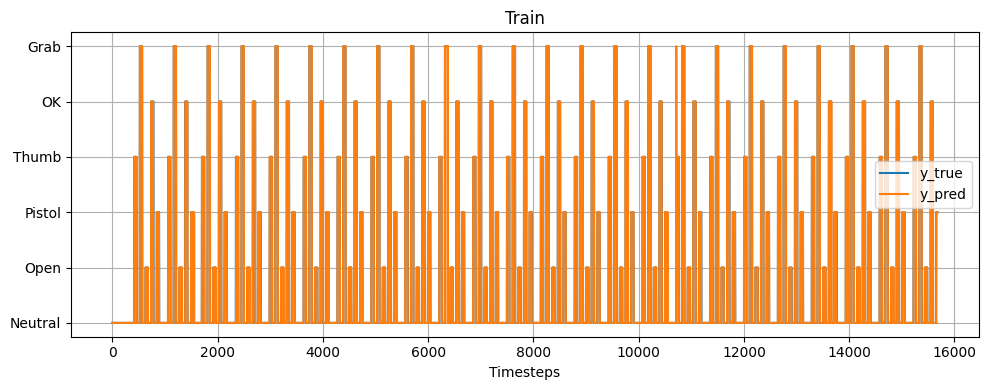

In [140]:
# График истинных и предсказанных значений таргета в тренировочных данных
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

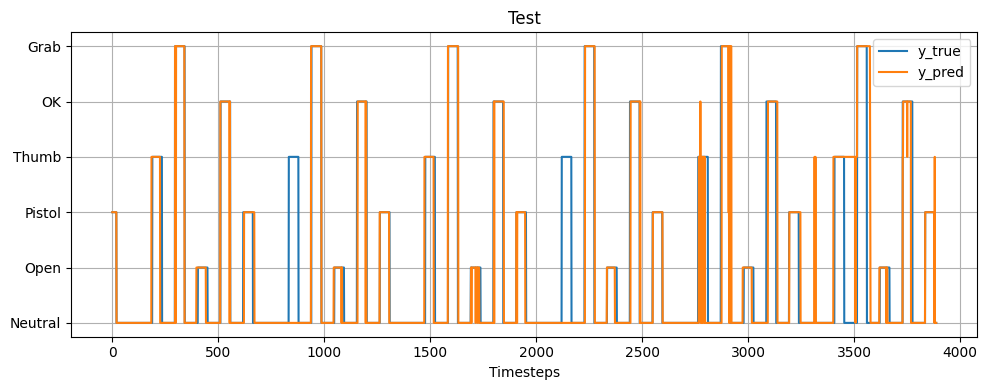

In [141]:
# График истинных и предсказанных значений таргета в тестовых данных
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [142]:
from sklearn.metrics import classification_report, f1_score

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.98      0.99      0.99     10171
        Open       0.98      0.95      0.96      1104
      Pistol       0.99      0.96      0.98      1078
       Thumb       0.99      0.96      0.97      1104
          OK       0.99      0.96      0.97      1104
        Grab       0.99      0.99      0.99      1118

    accuracy                           0.98     15679
   macro avg       0.99      0.97      0.98     15679
weighted avg       0.98      0.98      0.98     15679

              precision    recall  f1-score   support

     Neutral       0.91      0.94      0.92      2488
        Open       0.92      0.79      0.85       276
      Pistol       0.93      0.95      0.94       296
       Thumb       0.64      0.52      0.57       276
          OK       0.95      0.89      0.92       276
        Grab       0.91      0.94      0.93       277

    accuracy                           0.90      3889
   macro avg       0.88

# Real-time inference

In [143]:
import time
import serial
from IPython.display import clear_output

In [144]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [145]:
def preprocessing(x): # Предобработка входных данных
    # x - sample vector
    y = x
    return y

def inference(x): # Предикт модели на данных
    y = model.predict([x])
    return y

def postprocessing(x, prev): # Постобработка результатов модели, сглаживаем с предыдущим предиктом
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [146]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [160]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;
ts_list = []

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    # Проверяем что уложились в TIMEOUT
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_list.append(ts_diff)
    ts_old = ts_start
    i += 1 

ts_mean = np.array(ts_list).mean()
ts_mean

AssertionError: Calculation cycle takes more than TIMEOUT, halting...

In [101]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


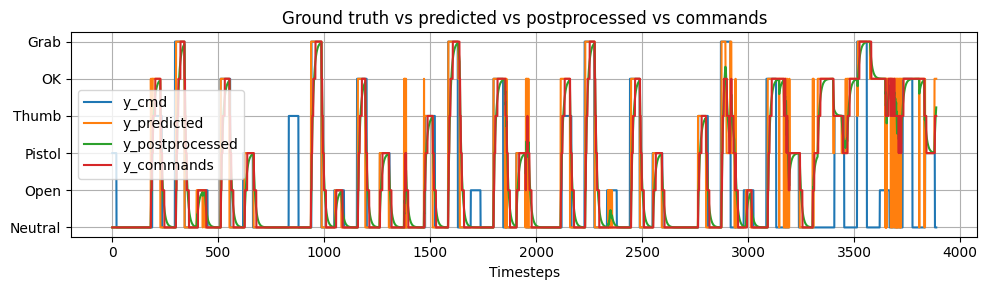

In [102]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [103]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.87      0.69      0.77      2488
        Open       0.23      0.33      0.27       276
      Pistol       0.48      0.69      0.56       296
       Thumb       0.32      0.41      0.36       276
          OK       0.26      0.55      0.36       276
        Grab       0.80      0.46      0.59       277

    accuracy                           0.62      3889
   macro avg       0.49      0.52      0.48      3889
weighted avg       0.71      0.62      0.65      3889



### Online (prosthesis or virtual hand)

In [66]:
if False:
    TIMEOUT = 0.033
    DEBUG = True
    
    ser = None
    # ser_port = None
    # ser_port = '/dev/ttyACM0'
    ser_port = '/dev/cu.usbmodem3498365F31351'
    
    if ser_port is not None:
        ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
        ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
        ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
        ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check
    
        # flush buffers
        ser.reset_input_buffer()
        ser.read()
        
        i = 0;
        while(ser.in_waiting):
            print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
            ser.read_all()
            time.sleep(0.005)
            i+=1;
        ser.readline()
        ser.readline()
        
    i = 0
    ts_old = time.time()
    ts_diff = 0;
    
    y_previous = None
    while True:    
        
        # [Data reading]
        s = ser.readline()
        ts_start = time.time()
        
        try:
            sample = np.array(s.decode('UTF-8')\
                               .replace('\r\n', "")\
                               .split(' ')
                             ).astype(int)
            [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
            
        except Exception as e:
            print(e)
            
        # [/Data Reading]
            
        # [Data preprocessing]
        sample_preprocessed = preprocessing(omg_sample)
        # [/Data preprocessing]
        
        # [Inference]
        y_predicted         = inference(sample_preprocessed)
        # [/Inference]
        
        # [Inference Postprocessing]
        y_postprocessed     = postprocessing(y_predicted, y_previous)
        # [/Inference Postprocessing]
        
        # [Commands composition]
        y_commands          = commands(y_postprocessed)
        # [/Commands composition]
        
        # [Commands sending]
        pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
        # [/Commands sending]
        
        y_previous = y_postprocessed
        
        if DEBUG:
            clear_output(wait=True)
    
            # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
            print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
            print('INPUT:\n', s)
    
            # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
            print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
            print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
            print(y_commands)
            print(pack)
        
        ts_diff = time.time() - ts_start
        assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
        ts_old = ts_start
        i += 1 

# Log into comet.ml

In [143]:
# Модель
model_name = 'RidgeClassifierCV'
experiment.log_text(text=model_name)

# Параметеры
experiment.log_parameters(model.get_params())

# Метрики
train_metrics = f1_score(y_train, y_pred_train, average='micro')
experiment.log_metric(name='train',value=train_metrics)
test_metrics = f1_score(y_test, y_pred_test, average='micro')
experiment.log_metric(name='test',value=test_metrics)
experiment.log_metric(name='ts_mean',value=ts_mean)

# Матрица ошибок
experiment.log_confusion_matrix(y_train.tolist(), y_pred_train.tolist())
experiment.log_confusion_matrix(y_test.tolist(), y_pred_test.tolist())

{'web': 'https://www.comet.com/api/asset/download?assetId=6aac04aefb1c49bf95a3be5af90ec7b4&experimentKey=0078034f2b224805a6ace24a15f65c33',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=6aac04aefb1c49bf95a3be5af90ec7b4&experimentKey=0078034f2b224805a6ace24a15f65c33',
 'assetId': '6aac04aefb1c49bf95a3be5af90ec7b4'}

In [79]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/morozovov/motorica/c78408c281994ba3ac6024f817312e49
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test [3]    : (0.8110053998457187, 0.890974543584469)
COMET INFO:     train [3]   : (0.9024810255756107, 0.9181708017092926)
COMET INFO:     ts_mean [3] : (0.00016355453220484158, 0.0002409342660116763)
COMET INFO:   Parameters:
COMET INFO:     Cs                   : 10
COMET INFO:     activation           : relu
COMET INFO:     alpha                : 0.0001
COMET INFO:     batch_size           : auto
COMET INFO:     beta_1               : 0.9
COMET INFO:     beta_2               : 0.999
COMET INFO:     class_weight     